<head> 
<style>
    h1 {text-align: center;}
</style>
</head>

<h1 style='font-size:40px'> CMSE 381 Honors Option </h1>
<h1>Collin Dobson</h1>
<h1>Dated: Nov 19, 2024</h1>


<h2 style='font-size:30px'> Introduction </h2>

<img src="NuclearReaction.png" alt="Nuclear Reaction" width="400" style="display: block; margin: auto;"/>
<h1 style='font-size:12px'> NuclearReaction. (n.d.). In Wikimedia Commons </h1>

&emsp;Two very important subjects in the field of nuclear physics are binding energy, and particle identification. The nucleus of atoms are made up of positively charged protons and neutrally charged neutrons, with negatively charged electrons somewhere outside of the nucleus "orbiting it". Much like in chemical bonds, the neutrons and protons in the nucleus are held together by some attractive force. This is called the strong nuclear force. Binding energy, or more accurately Nuclear Binding energy is the energy required to break apart a nucleus into its constituent parts, or in other words, overcome the pull of the strong nuclear force holding everything together. Binding energy is important because it governs what happens when you break a nucleus apart. When you break apart a nucleus it is much more likely that the resulting nuclei will be more stable, that is have a higher binding energy than the original nucleus. When these new nuclei form, assuming that they are more stable, they will release energy equal to the strength of the nuclear bond.

&emsp;On the other hand, particle identification is done in many different ways because different particles have different properties that can be drastically different, and because different detectors are more suited for different tasks. For neutral particles like neutrons or neutrinos detection is only possible through use of scintillators, which are materials that produce light when exposed to high energy particles. Usually these photons then hit a Photomultiplier Tube (PMT) that reconstructs the position of the interaction. For charged particles like protons or electrons they can just be measured by finding their velocity and momentum. This may be done by having two detectors separated by some distance that pick up particles excited by the particles of interest, and taking the timing difference. Then allowing the particle to collide with a calorimeter which outputs the momentum. Another method of particle identification may be done using what is called a time projection chamber. In a time projection chamber, high energy charged particles enter  through a port in one side travel through a medium, usually a high pressure gas, depart some energy to the gas as it passes through. As it deposits energy to the gas, electrons are kicked off of their host atoms float to the end of the chamber where they get picked up up electrodes. From these electrons, the path the particle traveled can be reconstructed. Then the properties of the particle can be determined by fitting known differential equations to the track.

&emsp;For this project I have selected two datasets. The first pertains to particle identification from a simulated detector, and the second is a table of binding energies and information about the nuclei, which will be used for regression. The end goal is to produce a model that can accurately classify the particles observed in a detector, and a model that can take information about a nuclei and output an estimate of the binding energy in KeV.

<h2 style='font-size:30px'> Imports </h2>

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

<h2 style='font-size:30px'> Particle ID </h2>

&emsp;In nuclear and particle physics it is quite common to use physics simulations to model the function of a detector. Often when a research group wants to design a new detector it is simply more cost effective to recreate said detector in a physics simulation. Tools like Geant4 and Nptool have been made for this exact purpose, and they are constantly being updated to improve the accuracy of the simulation. This data is from one such detector simulation.

&emsp;First we will begin by reading in the data from the particle identification dataset. This dataset is quite large (>25MB), so we will only read in the first 50,000 lines. There is a good mix of all of the different particles represented here, so it should be fine to just work with a subset. I have selected to use a Random Forest classifier and a Naive Bayesian classifier, as they produced the best results when I was doing preliminary testing. 

In [3]:
PID = pd.read_csv("PID_short.csv")
PID = PID.drop(PID.columns[0],axis=1) # First column is Unnamed 0, and is all zeros
PID = PID.iloc[0:50000]
PID['id'] = PID['id'].replace({211:0,2212:1,321:2,-11:3}) # There are 4 particles of interest in this set
PID.info()
PID['id'].unique() # positron (-11), pion (211), kaon (321), and proton (2212)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50000 non-null  int64  
 1   p       50000 non-null  float64
 2   theta   50000 non-null  float64
 3   beta    50000 non-null  float64
 4   nphe    50000 non-null  int64  
 5   ein     50000 non-null  float64
 6   eout    50000 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 2.7 MB


array([0, 1, 2, 3])

In [2]:
PID2 = pd.read_csv('pid-5M.csv')
PID2['id'] = PID2['id'].replace({211:0,2212:1,321:2,-11:3})

ids = [0,1,2,3]
frames = []

for i in ids:
    frames.append(PID2[PID2['id']==i].iloc[0:12500,:])

PID2 = pd.concat(frames)
PID2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 4224411
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50000 non-null  int64  
 1   p       50000 non-null  float64
 2   theta   50000 non-null  float64
 3   beta    50000 non-null  float64
 4   nphe    50000 non-null  int64  
 5   ein     50000 non-null  float64
 6   eout    50000 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 3.1 MB


&emsp;We start by replacing the previous particle IDs and replace them with simpler, easier to read values. positron which was -11 is now 3, pion which was 211 is now 0, kaon which was 321 is now 2, and proton which was 2212 is now 1. The data looks good, there are no null values, and all of the data types are numeric. We should be good to start classifying.

<h2 style='font-size:30px'> Separating Data into Predictor and Response </h2>

In [5]:
X = PID.drop("id",axis=1)
X_scaled = MinMaxScaler().fit_transform(X)
y = PID['id']
print(f"Shape of X:\n{X.shape}")
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.4 , random_state=1)
X_strain, X_stest , y_train, y_test = train_test_split(X_scaled, y, test_size=0.4 , random_state=1)

Shape of X:
(50000, 6)


In [3]:
X = PID2.drop("id",axis=1)
X_scaled = MinMaxScaler().fit_transform(X)
y = PID2['id']
print(f"Shape of X:\n{X.shape}")
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.4 , random_state=1)
X_strain, X_stest , y_train, y_test = train_test_split(X_scaled, y, test_size=0.4 , random_state=1)

Shape of X:
(50000, 6)


<h2 style='font-size:30px'> First Look </h2>

&emsp;For this set $n=50000$ and $p=6$. Lets get an idea for how well our models are able to predict on this data. Our 6 predictors are $p$ which is the momentum in GeV/c, $\theta$ which is the angle of the particle in the lab frame, $\beta$ which is the ratio of the velocity of the particle to the speed of light in the material, $nphe$ which is the number of photoelectrons produced in the scintillator, $ein$ which is the energy measured inside the first part of the detector, and lastly there is $eout$ which is the energy measured in the outer part of the detector.

&emsp;Let's start by getting an idea of what the relationships in the data look like. I will start by making some data visualizations to see if our models will be able to capitalize on trends in the data.

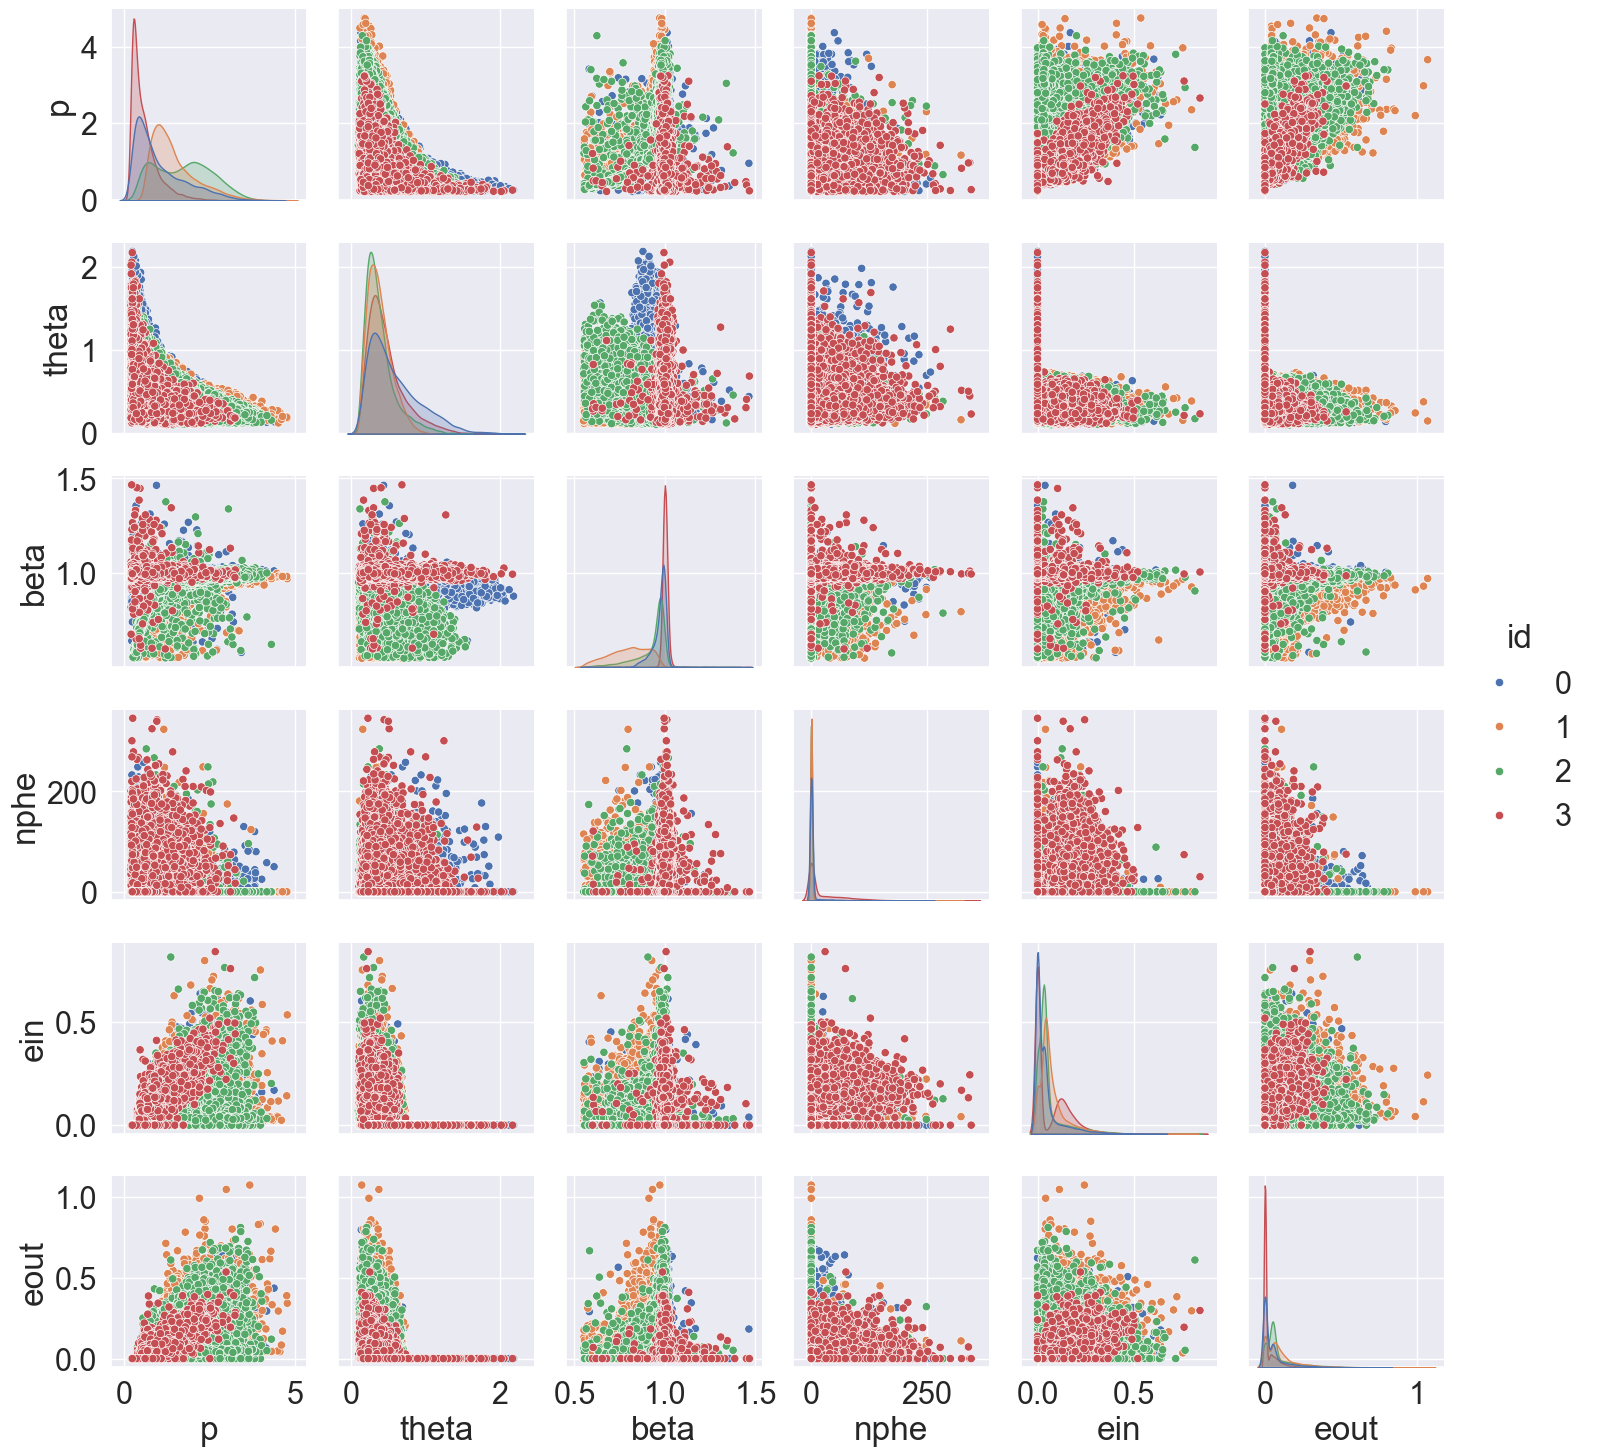

In [51]:
sns.set_theme(font_scale=2.0)
sns.pairplot(data=PID2,hue='id',palette="deep");

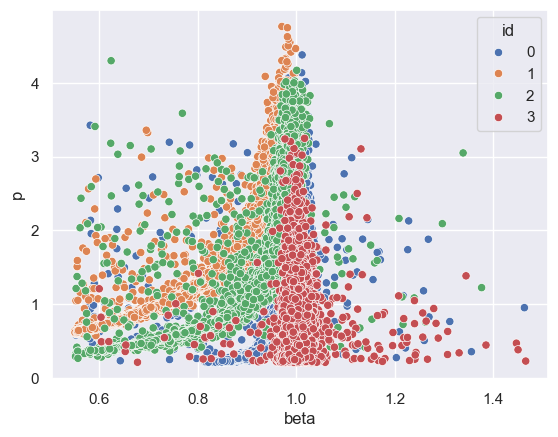

In [50]:
sns.set_theme(font_scale=1.0)
sns.scatterplot(data=PID2,x="beta",y='p',hue='id',palette='deep');

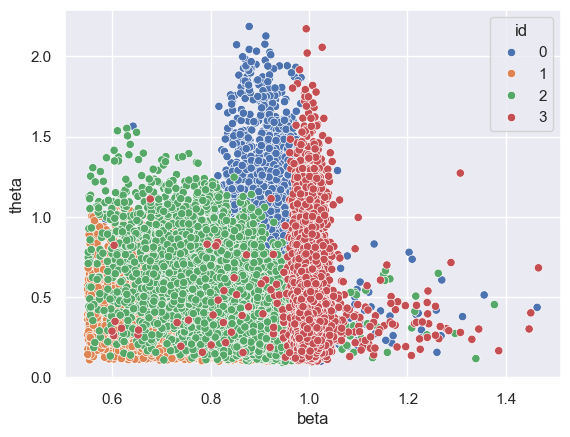

In [49]:
sns.set_theme(font_scale=1.0)
sns.scatterplot(data=PID2,y="theta",x='beta',hue='id',palette='deep');

In [ ]:
algo = RandomForestClassifier()

print(f"Accuracy: {100*cross_val_score(algo,X,y,cv=KFold(n_splits=5)).mean()}%")

algo.fit(X_train,y_train)
pred = algo.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=algo.classes_)
disp.plot();

Accuracy: 58.135999999999996%


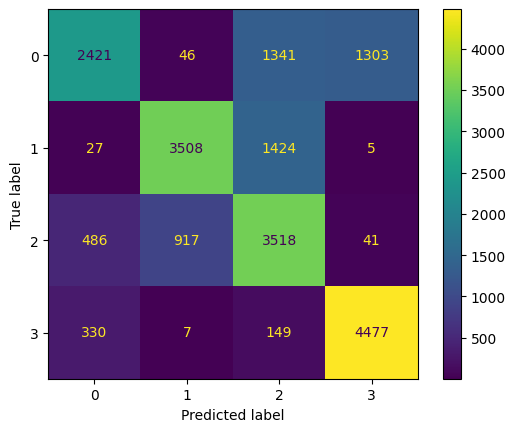

In [4]:
algo = GaussianNB()

print(f"Accuracy: {100*cross_val_score(algo,X,y,cv=KFold(n_splits=10)).mean()}%")

algo.fit(X_train,y_train)
pred = algo.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=algo.classes_)
disp.plot();

In [ ]:
algo = MLPClassifier(hidden_layer_sizes=(300,),max_iter=5000,solver='lbfgs',activation='logistic')

print(f"Accuracy: {100*cross_val_score(algo,X,y,cv=KFold(n_splits=5)).mean()}%")

algo.fit(X_train,y_train)
pred = algo.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=algo.classes_)
disp.plot();

Accuracy: 74.91799999999999%


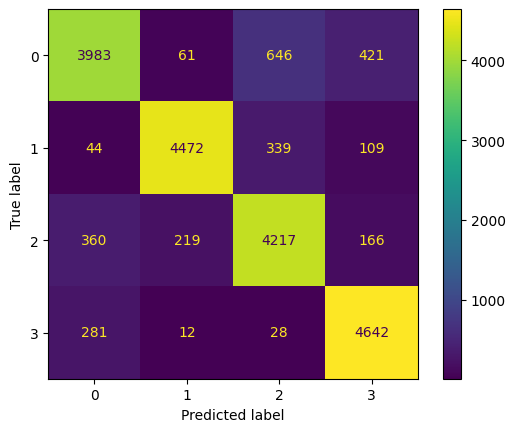

In [5]:
algo = KNeighborsClassifier()

print(f"Accuracy: {100*cross_val_score(algo,X,y,cv=KFold(n_splits=5)).mean()}%")

algo.fit(X_train,y_train)
pred = algo.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=algo.classes_)
disp.plot();

&emsp;Random Forest has very good out of the box performance as can be seen here. A 97% accuracy rate with no parameter tuning is fantastic. However It looks like we'll need to do some work on our Naive Bayes model here. Lets see how much more performance we can get out of both of them. I will start by performing a grid search for both to see what parameters are best.

In [ ]:
algo = RandomForestClassifier()

param_grid = {
    'max_features' : np.arange(35,55,5),
    'n_estimators' : np.arange(40,60,5),
    'max_depth' : np.arange(1,15,2),
}

grid = GridSearchCV(
    estimator=algo,
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid.fit(X,y)

print(f"Best Parameters:\n  {grid.best_params_}\nBest Score:\n  {grid.best_score_*100}%")

pred = grid.predict(X)

cm = confusion_matrix(y, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best Parameters:
  {'var_smoothing': 3.973730381485596e-11}
Best Score:
  58.144000000000005%


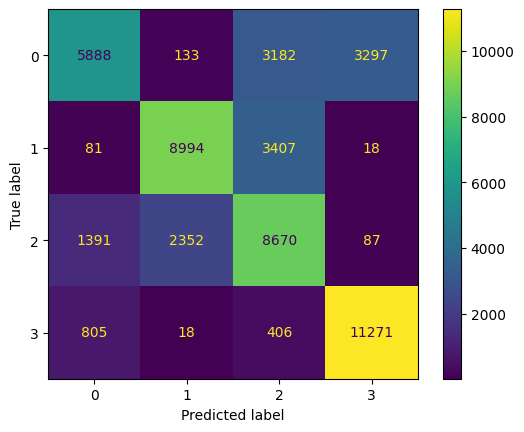

In [7]:
param_grid = {
    'var_smoothing':10**np.linspace(-30,-10,500)
}

grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    cv=KFold(n_splits=10),
    verbose=1,
    n_jobs=-1
)
grid.fit(X,y)
best_smoothing = grid.best_params_['var_smoothing']
algo = GaussianNB(var_smoothing=best_smoothing)

print(f"Best Parameters:\n  {grid.best_params_}\nBest Score:\n  {grid.best_score_*100}%")

pred = grid.predict(X)

cm = confusion_matrix(y, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters:
  {'n_neighbors': 3}
Best Score:
  75.89600000000002%


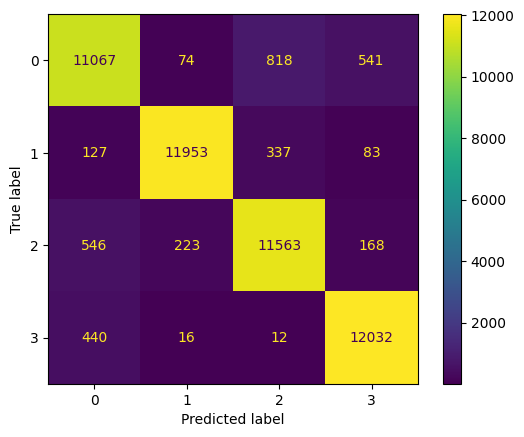

In [10]:
param_grid = {
    'n_neighbors':np.arange(2,20,1)
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)
grid.fit(X,y)

print(f"Best Parameters:\n  {grid.best_params_}\nBest Score:\n  {grid.best_score_*100}%")

pred = grid.predict(X)

cm = confusion_matrix(y, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

&emsp;Well it doesn't appear that parameter tuning did all that much for our models. Next let's see if increasing the variance with PCA will make either of our models perform better.

Fitting 5 folds for each of 112 candidates, totalling 560 fits


/Users/thatswhaticed/opt/anaconda3/envs/DataScience3_12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters:
  {'max_depth': 11, 'max_features': 40, 'n_estimators': 55}
Best Score:
  86.75%


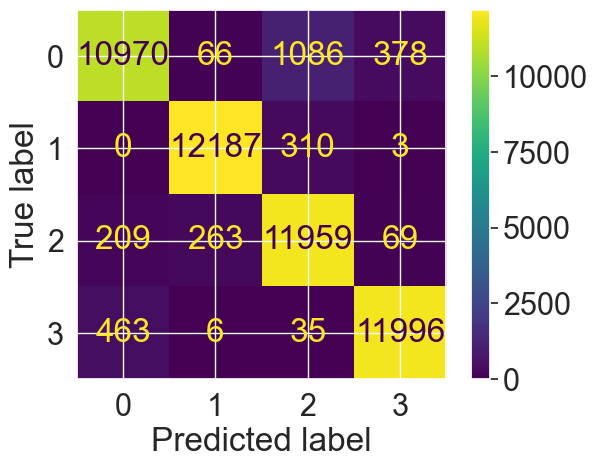

In [56]:
pca = PCA(n_components=4).fit(X) # 4 Dimensions seems to maximize the variance
X_pca = pca.transform(X)

algo = RandomForestClassifier()

param_grid = {
    'max_features' : np.arange(35,55,5),
    'n_estimators' : np.arange(40,60,5),
    'max_depth' : np.arange(1,15,2),
}

grid = GridSearchCV(
    estimator=algo,
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid.fit(X_pca,y)

print(f"Best Parameters:\n  {grid.best_params_}\nBest Score:\n  {grid.best_score_*100}%")

pred = grid.predict(X_pca)

cm = confusion_matrix(y, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best Parameters:
  {'var_smoothing': 1e-10}
Best Score:
  55.186%


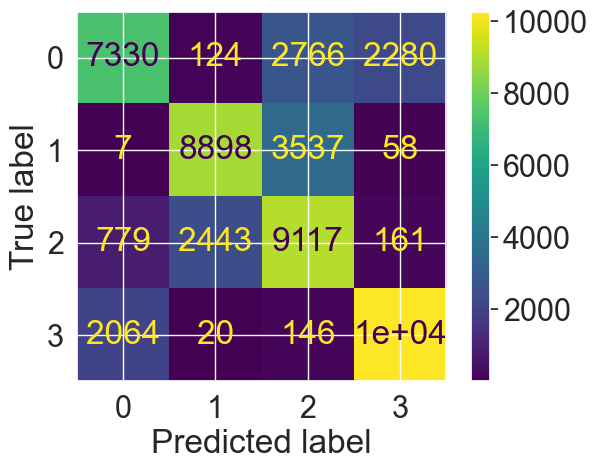

In [54]:
pca = PCA(n_components=4).fit(X) # Dimension reduction
X_pca = pca.transform(X)

param_grid = {
    'var_smoothing':10**np.linspace(-100,-10,500)
}

grid = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    cv=KFold(n_splits=10),
    verbose=1,
    n_jobs=-1
)
grid.fit(X_pca,y)

print(f"Best Parameters:\n  {grid.best_params_}\nBest Score:\n  {grid.best_score_*100}%")

pred = grid.predict(X_pca)

cm = confusion_matrix(y, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters:
  {'n_neighbors': 3}
Best Score:
  77.566%


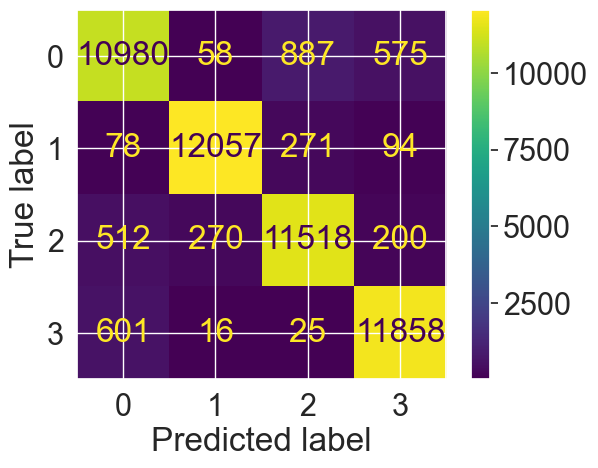

In [55]:
pca = PCA(n_components=4).fit(X) # Dimension reduction
X_pca = pca.transform(X)

param_grid = {
    'n_neighbors':np.arange(2,20,1)
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)
grid.fit(X_pca,y)

print(f"Best Parameters:\n  {grid.best_params_}\nBest Score:\n  {grid.best_score_*100}%")

pred = grid.predict(X_pca)

cm = confusion_matrix(y, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

&emsp;Well unfortunately PCA actually made our Random Forest less accurate, but we got about 5% more out of our Naive Bayes classifier. 

## Binding Energy

In [ ]:
AtomicMass = pd.read_csv("atomicMassData.csv")
AtomicMass['Z'] = AtomicMass['A'] - AtomicMass['N']

X = AtomicMass.drop(["BE","BE_uncer","EL"],axis=1)
y = AtomicMass["BE"]

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
sns.scatterplot(x=X['Z'],y=y)
plt.title("BE vs Z")
plt.grid(c='white')
# plt.legend(bbox_to_anchor = (1.05,1.));

In [ ]:
degs = list(range(1,10))
errors = []
for i in degs:
    polyfit = make_pipeline(PolynomialFeatures(degree=i,include_bias=False),LinearRegression())
    polyfit.fit(X,y)
    errors.append(mean_squared_error(polyfit.predict(X),y))

bestdegree = np.argmin(errors)+1
print("Best polynomial degree from kfold cv is:",bestdegree,"\nMSE:",errors[bestdegree-1])

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.xlabel('Degree of Polynomial')
plt.ylabel('MSE')
plt.xticks(degs)
plt.plot(degs,errors,c='salmon')
plt.scatter(degs,errors,c='salmon');

In [ ]:
polyfit = make_pipeline(PolynomialFeatures(degree=bestdegree,include_bias=False),LinearRegression())
polyfit.fit(X,y)
yhat = polyfit.predict(X)

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.scatter(X['A'],y,label="Real")
plt.scatter(X['A'],yhat,label="Predicted")
plt.title("BE vs A")
plt.xlabel("A")
plt.ylabel("BE")
plt.legend();

In [ ]:
alphas = 10**np.linspace(-1,1.5,1000)

errors = np.zeros(1000)

for i,a in enumerate(alphas):
    MODEL = make_pipeline(StandardScaler(), Lasso(alpha = a))
    errors[i] = -1*cross_val_score(MODEL,X, y, cv=KFold(n_splits=5), scoring='neg_mean_squared_error').mean()

minidx = np.argmin(errors)
print("Minimum MSE:",errors[minidx])
print("Alpha at min:",alphas[minidx])

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.title("MSE vs Alpha")
plt.plot(alphas,errors);
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

In [ ]:
coefs = []

for a in alphas:
    model = make_pipeline(StandardScaler(), Lasso(alpha = a))
    model.fit(X, y)
    coefs.append(model.named_steps['lasso'].coef_)
    
coefs = pd.DataFrame(coefs,columns = X.columns)

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.plot(alphas, coefs, label = coefs.columns)
plt.title("Coefficients vs Alpha")
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.axvline(x=alphas[minidx],linestyle='--',c='gray',label='Best $\\alpha$')
plt.legend(bbox_to_anchor = (1.05,1.01));
   

In [ ]:
lasso = Lasso(alpha=alphas[minidx]).fit(X,y)

yhat = lasso.predict(X)

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.scatter(X['A'],y,label="Real")
plt.scatter(X['A'],yhat,label="Predicted")
plt.title("BE vs A")
plt.xlabel("A")
plt.ylabel("BE")
plt.legend();

<h2 style='font-size:30px'> References </h2>

<ol>
    <li>NuclearReaction. (n.d.). In Wikimedia Commons. Retrieved November 19, 2024, from https://commons.wikimedia.org/wiki/File:NuclearReaction.svg</li>
</ol>